In this notebook, we illustrate a way to detect small airways in CT images based on persistent homology.

We try to extend the airway detection result using 3D slicer-LungCTSegmenter.

LungCTSegmenter is a good way to semi-automatically detect airways in lung CT images.

We might want to extend some of the detected airway branches, and this notebook provides one possible approach.

---------------------------------------------------------------------------
Note that there are some leaks in the current version, and the code will be modified a lot in the future.
---------------------------------------------------------------------------

In [1]:
import nrrd as nrrd
import pydicom as dicom
import cv2
import homcloud.interface as hc
import numpy as np
import matplotlib.pyplot as plt
import copy
import napari
from napari.utils import nbscreenshot

In [2]:
###Load the segmentation result using 3D slicer-LungCTSegmenter
readdata, header = nrrd.read('PATH_TO_DATA\Lung segmentation.seg.nrrd')
h,w,z=readdata[3].shape
airway_3dslicer=[np.transpose(readdata[3][:,:,z-i-1]) for i in range (0,z)]
airway_3dslicer=np.array(airway_3dslicer)

In [3]:
###Load the image data
lungImage=[]
for i in range (0,305):
    if i+1<10:
        d = dicom.read_file('PATH_TO_DATA\1-00'+str(i+1)+'.dcm')
    elif i+1<100:
        d = dicom.read_file('PATH_TO_DATA\1-0'+str(i+1)+'.dcm')
    else:
        d = dicom.read_file('PATH_TO_DATA\1-'+str(i+1)+'.dcm')
    lungImage.append(d.pixel_array)
lungImage=np.array(lungImage)

In [4]:
viewer=napari.view_image(lungImage)
viewer.add_image(airway_3dslicer)

Assistant skips harvesting pyclesperanto as it's not installed.


<Image layer 'airway_3dslicer' at 0x1699d7cbd00>

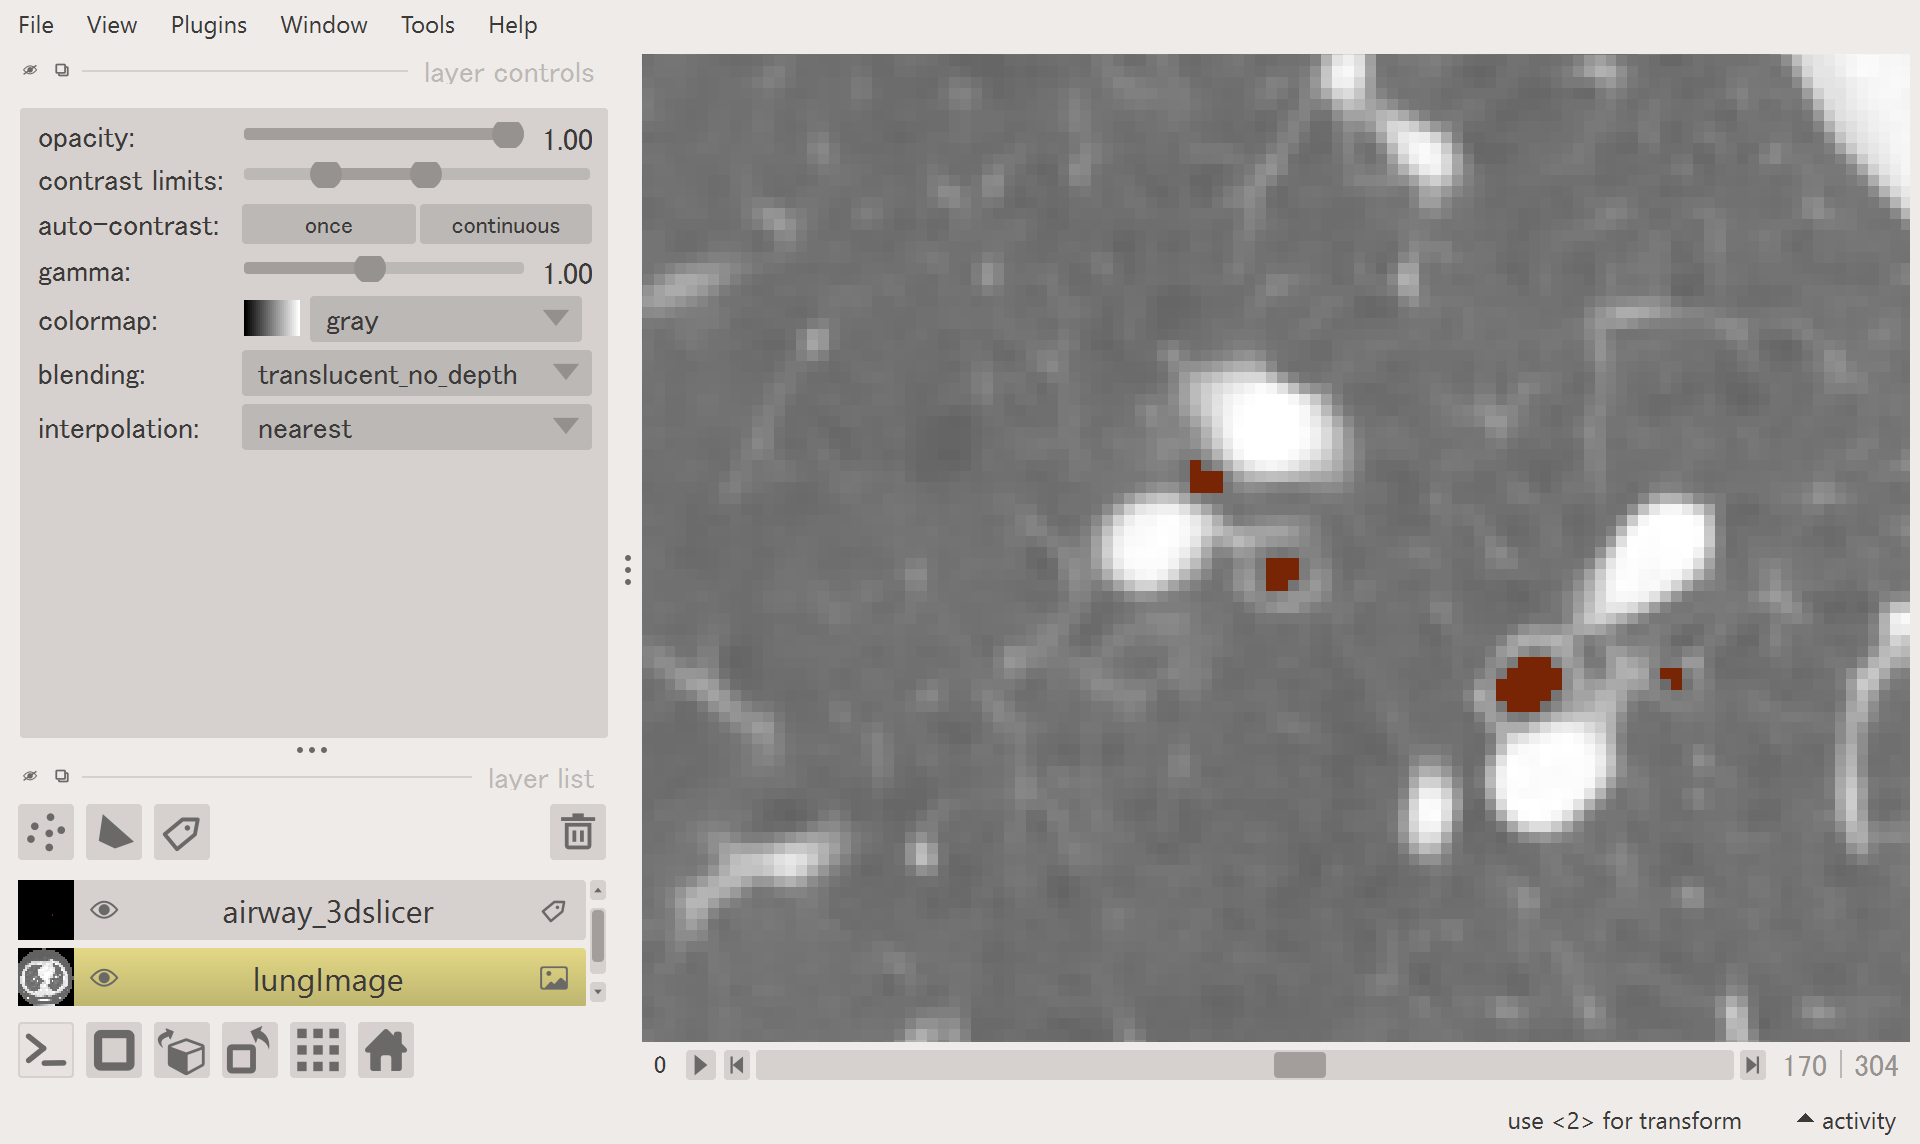

In [8]:
nbscreenshot(viewer)

In [ ]:
###We want to continue tracking the airway in the center of the above screenshot.

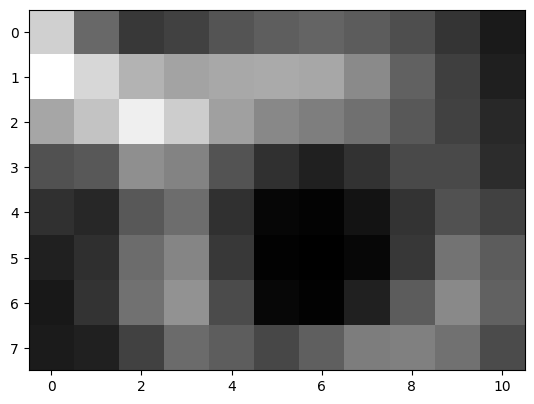

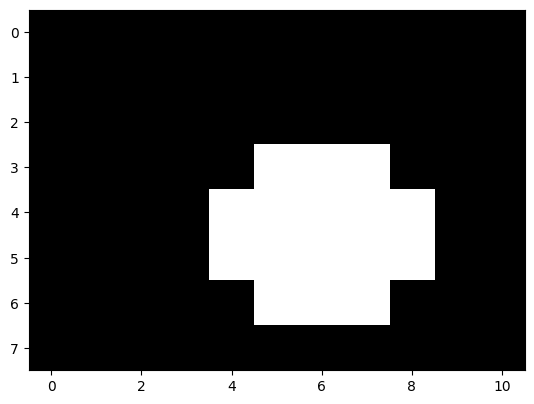

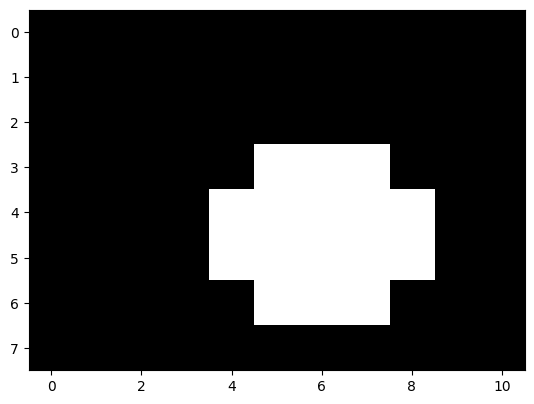

In [4]:
###Specify the region to focus on.
z1=170
x1=276
x2=284
y1=161
y2=172
pict=lungImage[z1][x1:x2,y1:y2]
plt.imshow(pict,cmap='gray')
plt.show()
hc.BitmapPHTrees.for_bitmap_levelset(pict, "superlevel", save_to="grayscale-tree.pdgm")
phtrees = hc.PDList("grayscale-tree.pdgm").bitmap_phtrees(1)
h,w=pict.shape
mask=np.zeros((h,w))
for i in range (0,len(phtrees.nodes)):
    node=phtrees.nodes[i]
    spots=np.array(node.volume())
    spots_tr=np.transpose(spots)
    mask[(spots_tr[0],spots_tr[1])]=255
plt.imshow(mask,cmap='gray')
plt.show()
starting_mask=np.zeros((h,w))
node=phtrees.nodes[0]###If you detect multiple nodes, you can specify the one of your interest here.
spots=np.array(node.volume())
spots_tr=np.transpose(spots)
starting_mask[(spots_tr[0],spots_tr[1])]=255
plt.imshow(starting_mask,cmap='gray')
plt.show()

In [5]:
sliceNum=50###This number shows how long we want to extend the airway.
lifeThres=10###Threshold value of lifetime (persistence) for a structure to be regarded as significant.
epsilon=10###The parameter for stable volume. This allows us to avoid too large node volumes.
H,W=lungImage[0].shape
allblack_bg=np.zeros((H,W))
mask_list=[[] for k in range (0,sliceNum)]
starting_mask_wholelung=copy.deepcopy(allblack_bg)
starting_mask_wholelung[x1:x2,y1:y2]=starting_mask
mask_list[0]=[starting_mask_wholelung]
margin=3
for i in range (0,sliceNum-1):
    print('Processing', i)
    currentSlice=mask_list[i]#####detected airways are recorded here.
    for j in range (0,len(currentSlice)):
        currentMask=currentSlice[j]
        dilated_currentMask=cv2.dilate(currentMask.astype('uint8'),kernel=np.array([[1,1,1],[1,1,1],[1,1,1]],dtype='uint8'),iterations=1)
        spots=np.where(dilated_currentMask)
        next_x1=np.min(spots[0])-margin
        next_x2=np.max(spots[0])+margin
        next_y1=np.min(spots[1])-margin
        next_y2=np.max(spots[1])+margin
        pict=lungImage[z1+i+1][next_x1:next_x2,next_y1:next_y2]
        hc.BitmapPHTrees.for_bitmap_levelset(pict, "superlevel", save_to="grayscale-tree.pdgm")
        phtrees = hc.PDList("grayscale-tree.pdgm").bitmap_phtrees(1)
        h,w=pict.shape
        for k in range (0,len(phtrees.nodes)):
            mask_candidate=np.zeros((h,w))
            node=phtrees.nodes[k]
            if node.lifetime()<-lifeThres:
                spots=np.array(node.stable_volume(epsilon).volume())
                spots_tr=np.transpose(spots)
                mask_candidate[(spots_tr[0],spots_tr[1])]=255
                mask_candidate_wholelung=copy.deepcopy(allblack_bg)
                mask_candidate_wholelung[next_x1:next_x2,next_y1:next_y2]=mask_candidate
                dilated_mask_candidate_wholelung=cv2.dilate(mask_candidate_wholelung.astype('uint8'),kernel=np.array([[1,1,1],[1,1,1],[1,1,1]],dtype='uint8'),iterations=1)
                overlap=dilated_mask_candidate_wholelung*currentMask####Check whether the regions overlap.
                if len(np.where(overlap)[0])>0:
                    mask_list[i+1].append(mask_candidate_wholelung)

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9
Processing 10
Processing 11
Processing 12
Processing 13
Processing 14
Processing 15
Processing 16
Processing 17
Processing 18
Processing 19
Processing 20
Processing 21
Processing 22
Processing 23
Processing 24
Processing 25
Processing 26
Processing 27
Processing 28
Processing 29
Processing 30
Processing 31
Processing 32
Processing 33
Processing 34
Processing 35
Processing 36
Processing 37
Processing 38
Processing 39
Processing 40
Processing 41
Processing 42
Processing 43
Processing 44
Processing 45
Processing 46
Processing 47
Processing 48


In [6]:
###Make sure there is no slice where no structure is detected (because we cannot form array).
###If this is the case, reduce the silceNum above.
mask_slices=[]
for i in range (0,len(mask_list)):
    current_slice=np.array(mask_list[i])
    mask_slices.append(np.sum(current_slice,axis=0))
mask_slices=np.array(mask_slices)>0  
PHlabels=np.zeros((len(lungImage),H,W))
PHlabels[z1:z1+sliceNum]=mask_slices

In [13]:
viewer.add_image(PHlabels)

<Image layer 'PHlabels' at 0x16a0d572860>

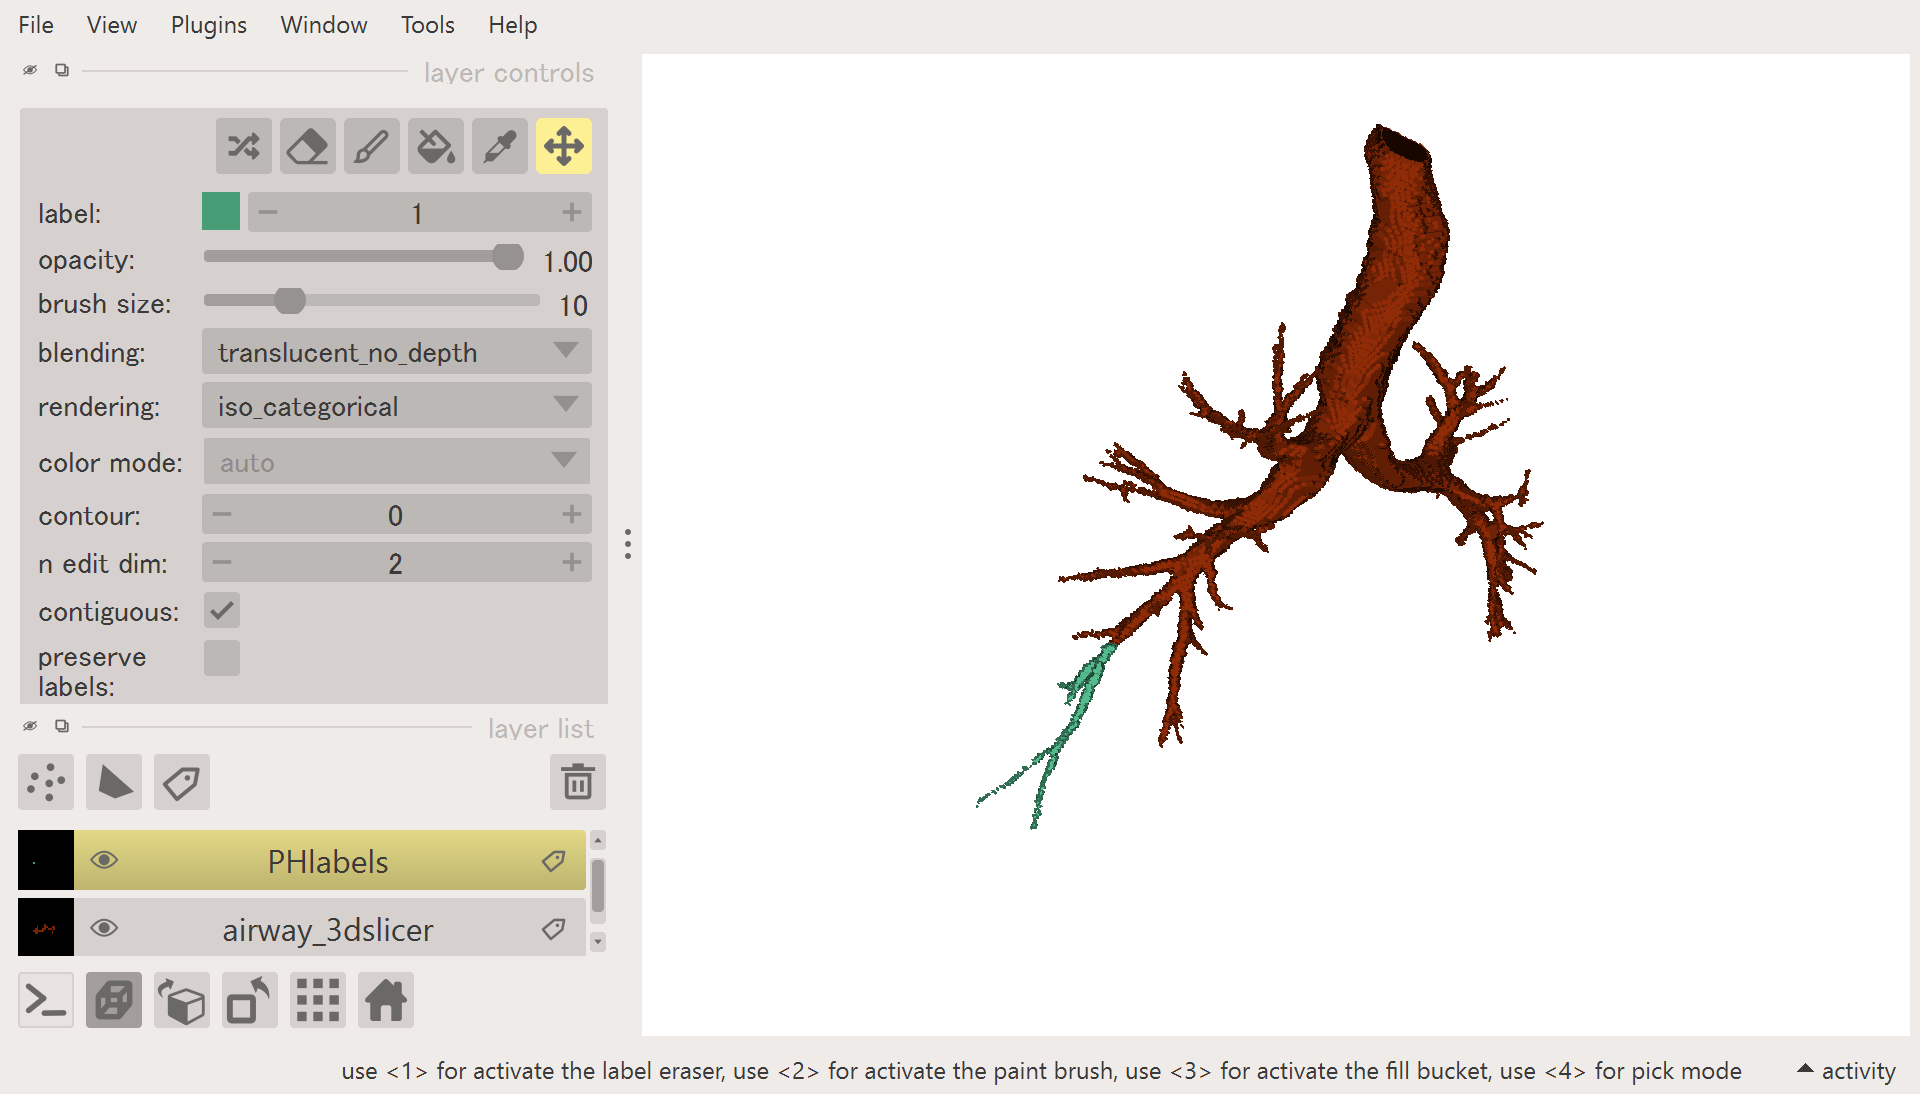

In [15]:
###We extended the detected airway.
nbscreenshot(viewer)